In [ ]:
import os
import json
import shutil
import requests
import zipfile
import random
from datetime import datetime
from PIL import Image, UnidentifiedImageError
from concurrent.futures import ThreadPoolExecutor, as_completed
from google.colab import drive

# -------------------- CONFIG --------------------
FILE_PATH = "/content/memories_history.json"
DOWNLOAD_DIR = "all_unique_images"
MERGED_DIR = "merged_images"
DRIVE_BACKUP_PATH = '/content/drive/MyDrive/Snapchat_Memories_testing'
MAX_THREADS = 8

os.makedirs(DOWNLOAD_DIR, exist_ok=True)
os.makedirs(MERGED_DIR, exist_ok=True)

# -------------------- STEP 1: Load JSON & Filter --------------------
with open(FILE_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

memories = next(v for v in data.values() if isinstance(v, list)) if isinstance(data, dict) else data

unique_json_map = {}
for item in memories:
    if item.get("Media Type") == "Image" and item.get("Date") and item.get("Media Download Url"):
        date_key = item["Date"]
        if date_key not in unique_json_map:
            unique_json_map[date_key] = item

unique_images_list = list(unique_json_map.values())
for item in unique_images_list:
    item["_parsed_date"] = datetime.strptime(item["Date"], "%Y-%m-%d %H:%M:%S UTC")

unique_images_list.sort(key=lambda x: x["_parsed_date"], reverse=True)
print(f"🧹 Unique metadata entries found: {len(unique_images_list)}")

# -------------------- STEP 2: Concurrent Download --------------------
def download_image(idx_item):
    idx, item = idx_item
    url = item["Media Download Url"]
    date_str = item["_parsed_date"].strftime("%Y%m%d_%H%M%S")
    file_path = os.path.join(DOWNLOAD_DIR, f"image_{idx}_{date_str}.jpg")
    try:
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        with open(file_path, "wb") as f:
            f.write(response.content)
        return file_path, item["Date"]
    except:
        return None, None

downloaded_map = {}
with ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
    futures = [executor.submit(download_image, (idx, item)) for idx, item in enumerate(unique_images_list, 1)]
    for future in as_completed(futures):
        path, d_key = future.result()
        if path: downloaded_map[path] = d_key

# -------------------- STEP 3: Process Overlays & Validate --------------------
final_local_data = [] # List of {'path': local_path, 'date_key': date}

def process_file(file_path):
    d_key = downloaded_map[file_path]
    try:
        with Image.open(file_path) as img:
            img.verify()
        return file_path, d_key
    except:
        if zipfile.is_zipfile(file_path):
            with zipfile.ZipFile(file_path, 'r') as z:
                main = next((x for x in z.namelist() if "main" in x.lower()), None)
                over = next((x for x in z.namelist() if "overlay" in x.lower()), None)
                if main and over:
                    with z.open(main) as m, z.open(over) as o:
                        m_img, o_img = Image.open(m).convert("RGBA"), Image.open(o).convert("RGBA")
                        if o_img.size != m_img.size:
                            o_img = o_img.resize(m_img.size, Image.Resampling.LANCZOS)
                        combined = Image.alpha_composite(m_img, o_img)
                        # Filename fix: Use original name but add _merged suffix
                        base_name = os.path.splitext(os.path.basename(file_path))[0]
                        out = os.path.join(MERGED_DIR, f"{base_name}_merged.jpg")
                        combined.convert("RGB").save(out, "JPEG", quality=95)
                        return out, d_key
    return None, None

with ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
    futures = [executor.submit(process_file, f) for f in downloaded_map.keys()]
    for future in as_completed(futures):
        res_path, res_date = future.result()
        if res_path:
            final_local_data.append({"path": res_path, "date_key": res_date})

# -------------------- STEP 4: Drive Backup --------------------
#drive.mount('/content/drive')
os.makedirs(DRIVE_BACKUP_PATH, exist_ok=True)

print(f"🚀 Backing up {len(final_local_data)} images to Google Drive...")
for entry in final_local_data:
    shutil.copy2(entry["path"], os.path.join(DRIVE_BACKUP_PATH, os.path.basename(entry["path"])))

# -------------------- STEP 5: BUILD CORRECTED INDEX --------------------
# We pull filenames directly from Drive to ensure 100% accuracy
master_index = []
drive_files = os.listdir(DRIVE_BACKUP_PATH)

for date_key, metadata in unique_json_map.items():
    # Find file on Drive that contains this timestamp
    date_str_match = metadata["_parsed_date"].strftime("%Y%m%d_%H%M%S")
    actual_filename = next((f for f in drive_files if date_str_match in f), None)

    if actual_filename:
        master_index.append({
            "Drive File Path": os.path.join(DRIVE_BACKUP_PATH, actual_filename),
            "Filename": actual_filename,
            "Date": metadata.get("Date"),
            "Year": metadata.get("Date")[:4],
            "Location": metadata.get("Location"),
            "Media Type": metadata.get("Media Type")
        })

# Save Index to Drive
INDEX_FILE_DRIVE = os.path.join(DRIVE_BACKUP_PATH, "memories_master_index.json")
with open(INDEX_FILE_DRIVE, "w", encoding="utf-8") as f:
    json.dump(master_index, f, indent=4)

print(f"✅ Pipeline Complete!")
print(f"📁 Images & Index saved to: {DRIVE_BACKUP_PATH}")

🧹 Unique metadata entries found: 1980
🚀 Backing up 1980 images to Google Drive...
✅ Pipeline Complete!
📁 Images & Index saved to: /content/drive/MyDrive/Snapchat_Memories_testing


In [1]:
# 1. Core Data & Request Libraries
!pip install -q requests tqdm pillow

# 2. Machine Learning Frameworks (CLIP & Florence-2)
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q transformers accelerate bitsandbytes

# 3. Vector Search & Performance
!pip install -q faiss-cpu


# 1. Install Ninja first (speeds up and fixes many build errors)
!pip install ninja

# 2. Install flash-attn without build isolation
# This allows it to see the already installed torch/cuda versions
!pip install flash-attn --no-build-isolation

# 5. Visualization
!pip install -q matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 45.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.8.3-cp312-cp312-linux_x86_64.whl size=253780426 sha256=4e2f9e39313266b1544b68138b15b91ee6221eccf14f7902b7c6620351340810
  Stored in directory: /root/.cache/pip/wheels/3d/59/46/f282c12c73dd4bb3c2e3fe199f1a0d0f8cec06df0cccfeee27
Successfully built flash-attn


In [2]:
import os, json, torch, faiss, textwrap, random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from datetime import datetime
from google.colab import drive
from transformers import (
    CLIPProcessor, CLIPModel,
    AutoProcessor, AutoModelForCausalLM
)

# -------------------- CONFIG & PATHS --------------------
#drive.mount('/content/drive')
# The source index created in the previous step
MASTER_INDEX_PATH = "/content/drive/MyDrive/Snapchat_Memories_testing/memories_master_index.json"
# Where to save the new vector search indices
INDEX_DIR = "/content/drive/MyDrive/Snapchat_Memories_testing/search_indices"
os.makedirs(INDEX_DIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🚀 Using device: {device}")

# -------------------- STEP 1: LOAD MASTER DATA --------------------
with open(MASTER_INDEX_PATH, "r", encoding="utf-8") as f:
    master_data = json.load(f)

# all_images is now a list of Drive paths directly from your index
all_image_paths = [item["Drive File Path"] for item in master_data]
print(f"✅ Loaded {len(all_image_paths)} images from Master Index.")


# -------------------- STEP 2: LOAD MODELS (FIXED) --------------------
# CLIP for visual/text embedding
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

# Florence-2 for detailed captions
# FIX: Added attn_implementation="eager" to bypass the SDPA attribute error
print("🤖 Loading Florence-2 (this may take a minute)...")
florence_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Florence-2-large",
    trust_remote_code=True,
    dtype=torch.float16 if device == "cuda" else torch.float32,
    attn_implementation="eager"  # This prevents the '_supports_sdpa' error
).to(device).eval()

florence_processor = AutoProcessor.from_pretrained(
    "microsoft/Florence-2-large",
    trust_remote_code=True
)


# -------------------- STEP 3: GENERATE DETAILED CAPTIONS --------------------
# This uses Florence-2 to 'look' at your memories and describe them
id_to_caption = {}
model_dtype = next(florence_model.parameters()).dtype

print("✍️ Generating detailed captions (Florence-2)...")
for idx, path in tqdm(enumerate(all_image_paths), total=len(all_image_paths)):
    try:
        image = Image.open(path).convert("RGB")
        inputs = florence_processor(text="<DETAILED_CAPTION>", images=image, return_tensors="pt")

        with torch.no_grad():
            output_ids = florence_model.generate(
                input_ids=inputs["input_ids"].to(device),
                pixel_values=inputs["pixel_values"].to(device, dtype=model_dtype),
                max_new_tokens=64, use_cache=False
            )

        caption = florence_processor.batch_decode(output_ids, skip_special_tokens=True)[0]
        id_to_caption[str(idx)] = caption
        image.close()
    except Exception as e:
        id_to_caption[str(idx)] = "Caption generation failed."

# -------------------- STEP 4: BUILD VECTOR INDICES (FAISS) --------------------
def normalize(x):
    return x / np.linalg.norm(x, axis=1, keepdims=True)

img_embeddings = []
print("🖼️ Embedding images (CLIP)...")
for i in tqdm(range(0, len(all_image_paths), 8)):
    batch_paths = all_image_paths[i:i+8]
    imgs = [Image.open(p).convert("RGB") for p in batch_paths]
    inputs = clip_processor(images=imgs, return_tensors="pt", padding=True).to(device)

    with torch.no_grad():
        feats = clip_model.get_image_features(**inputs)
    img_embeddings.append(feats.cpu().numpy())
    for im in imgs: im.close()

# Build Image Index
image_vecs = normalize(np.vstack(img_embeddings).astype("float32"))
img_index = faiss.IndexFlatIP(image_vecs.shape[1])
img_index.add(image_vecs)

# Build Caption Index
print("🔤 Embedding captions (CLIP)...")
captions_list = list(id_to_caption.values())
cap_embeddings = []
for i in tqdm(range(0, len(captions_list), 32)):
    batch = captions_list[i:i+32]
    inputs = clip_processor(text=batch, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        feats = clip_model.get_text_features(**inputs)
    cap_embeddings.append(feats.cpu().numpy())

caption_vecs = normalize(np.vstack(cap_embeddings).astype("float32"))
cap_index = faiss.IndexFlatIP(caption_vecs.shape[1])
cap_index.add(caption_vecs)

# -------------------- STEP 5: SAVE SEARCH DATA --------------------
# We save these back to your Drive so you never have to generate them again!
faiss.write_index(img_index, f"{INDEX_DIR}/clip_image.index")
faiss.write_index(cap_index, f"{INDEX_DIR}/caption_text.index")
with open(f"{INDEX_DIR}/id_to_caption.json", "w") as f:
    json.dump(id_to_caption, f)

print(f"✅ All search indices saved to Drive: {INDEX_DIR}")



🚀 Using device: cuda
✅ Loaded 1980 images from Master Index.


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/590 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-large-patch14
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
vision_model.embeddings.position_ids | UNEXPECTED |  | 
text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [3]:
def search_memories(query, top_k=5, alpha=0.7):
    if not query.strip():
        raise ValueError("Query cannot be empty")

    # 1. Embed query
    inputs = clip_processor(text=[query], return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        q_emb = clip_model.get_text_features(**inputs).cpu().numpy()
    q_emb = q_emb / np.linalg.norm(q_emb, axis=1, keepdims=True)

    # 2. Search both indices
    K = max(50, top_k)
    sim_img, idx_img = img_index.search(q_emb.astype("float32"), K)
    sim_txt, idx_txt = cap_index.search(q_emb.astype("float32"), K)

    scores = {}

    # 3. Collect visual scores
    for score, idx in zip(sim_img[0], idx_img[0]):
        scores.setdefault(idx, {})["visual"] = score

    # 4. Collect textual scores
    for score, idx in zip(sim_txt[0], idx_txt[0]):
        scores.setdefault(idx, {})["text"] = score

    # 5. Weighted sum
    results = []
    for idx, sc in scores.items():
        text_score = sc.get("text", 0.0)
        visual_score = sc.get("visual", 0.0)
        final_score = alpha * text_score + (1 - alpha) * visual_score

        results.append({
            "data": master_data[idx],
            "caption": id_to_caption[str(idx)],
            "score": final_score
        })

    # 6. Sort
    results.sort(key=lambda x: x["score"], reverse=True)

    return results[:top_k]


In [62]:

# -------------------- TEST SEARCH --------------------
query = "show me images when I was enjoying in the rain"
matches = search_memories(query)

fig, axes = plt.subplots(1, len(matches), figsize=(20, 5))
for ax, res in zip(axes, matches):
    img = Image.open(res["data"]["Drive File Path"])
    ax.imshow(img)
    ax.set_title(f"Score: {res['score']:.2f}\n{res['data']['Date']}\n{res['data']['Location']}", fontsize=8)
    ax.axis("off")
plt.show()

#**Inferencing Code**

In [7]:
!pip install -q torch transformers faiss-cpu pillow matplotlib


In [8]:
import json
import faiss
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import CLIPProcessor, CLIPModel


In [9]:
# -------------------- CONFIG --------------------
BASE_DIR = "/content/drive/MyDrive/Snapchat_Memories_testing"

MASTER_INDEX_PATH = f"{BASE_DIR}/memories_master_index.json"
INDEX_DIR = f"{BASE_DIR}/search_indices"

IMAGE_INDEX_PATH = f"{INDEX_DIR}/clip_image.index"
CAPTION_INDEX_PATH = f"{INDEX_DIR}/caption_text.index"
CAPTION_MAP_PATH = f"{INDEX_DIR}/id_to_caption.json"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TOP_K_DEFAULT = 5


In [10]:
print("📦 Loading metadata & indices...")

with open(MASTER_INDEX_PATH, "r") as f:
    master_data = json.load(f)

with open(CAPTION_MAP_PATH, "r") as f:
    id_to_caption = json.load(f)

img_index = faiss.read_index(IMAGE_INDEX_PATH)
cap_index = faiss.read_index(CAPTION_INDEX_PATH)

print(f"✅ Loaded {len(master_data)} images")


📦 Loading metadata & indices...
✅ Loaded 1980 images


In [11]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(DEVICE).eval()
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")


Loading weights:   0%|          | 0/590 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-large-patch14
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
vision_model.embeddings.position_ids | UNEXPECTED |  | 
text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [16]:
def normalize(x):
    return x / np.linalg.norm(x, axis=1, keepdims=True)


In [25]:
def search_memories(
    query: str,
    top_k: int = 5,
    text_weight: float = 0.7,     # 🔤 importance of caption/text similarity
    visual_weight: float = 0.3,   # 🖼️ importance of visual similarity
    debug: bool = False
):
    """
    Multimodal search over Snapchat memories using late fusion.
    text_weight + visual_weight should sum to 1.0
    """

    if not query.strip():
        raise ValueError("Query cannot be empty")

    # -------------------- 1. Encode query (TEXT) --------------------
    inputs = clip_processor(text=[query], return_tensors="pt", padding=True).to(DEVICE)

    with torch.no_grad():
        outputs = clip_model.get_text_features(**inputs)
        query_text_embedding = (
            outputs if isinstance(outputs, torch.Tensor)
            else outputs.pooler_output
        )

    query_text_embedding = query_text_embedding.cpu().numpy()
    query_text_embedding = normalize(query_text_embedding.astype("float32"))

    # -------------------- 2. FAISS search --------------------
    K = max(50, top_k)

    # Visual similarity (image embeddings vs text query)
    visual_scores, visual_indices = img_index.search(query_text_embedding, K)

    # Textual similarity (caption embeddings vs text query)
    text_scores, text_indices = cap_index.search(query_text_embedding, K)

    # -------------------- 3. Collect scores --------------------
    fused_scores = {}

    # Visual scores
    for score, idx in zip(visual_scores[0], visual_indices[0]):
        fused_scores.setdefault(idx, {})["visual_score"] = float(score)

    # Text scores
    for score, idx in zip(text_scores[0], text_indices[0]):
        fused_scores.setdefault(idx, {})["text_score"] = float(score)

    # -------------------- 4. Weighted late fusion --------------------
    results = []

    for idx, sc in fused_scores.items():
        text_score = sc.get("text_score", 0.0)
        visual_score = sc.get("visual_score", 0.0)

        final_score = (
            text_weight * text_score +
            visual_weight * visual_score
        )

        result = {
            "image_path": master_data[idx]["Drive File Path"],
            "date": master_data[idx].get("Date"),
            "location": master_data[idx].get("Location"),
            "caption": id_to_caption.get(str(idx), ""),
            "text_score": text_score,         # 🔤 explicit
            "visual_score": visual_score,     # 🖼️ explicit
            "final_score": final_score        # 🔥 fused
        }

        results.append(result)

    # -------------------- 5. Sort & return --------------------
    results.sort(key=lambda x: x["final_score"], reverse=True)

    if debug:
        for r in results[:top_k]:
            print(
                f"FINAL: {r['final_score']:.3f} | "
                f"TEXT: {r['text_score']:.3f} | "
                f"VISUAL: {r['visual_score']:.3f}\n"
                f"Caption: {r['caption']}\n"
            )

    return results[:top_k]


In [49]:
import textwrap
import matplotlib.pyplot as plt
from PIL import Image
import math

def show_ranked_results(results, query, max_cols=3, wrap_width=40):
    """
    Display ranked images with readable captions and scores.
    - wrap_width: max characters per line for captions
    """

    if len(results) == 0:
        print("No results to display")
        return

    n = len(results)
    cols = min(max_cols, n)
    rows = math.ceil(n / cols)

    plt.figure(figsize=(6 * cols, 6 * rows))
    plt.suptitle(f"Query: {query}", fontsize=16)

    for i, res in enumerate(results):
        img = Image.open(res["image_path"]).convert("RGB")

        # Wrap caption
        wrapped_caption = "\n".join(textwrap.wrap(res["caption"], width=wrap_width))

        # Build title
        title = (
            f"Rank #{i+1}\n"
            f"Final: {res['final_score']:.3f} | "
            f"Text: {res['text_score']:.3f} | "
            f"Visual: {res['visual_score']:.3f}\n"
            f"{wrapped_caption}"
        )

        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(img)
        ax.set_title(title, fontsize=10)
        ax.axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
    plt.show()


FINAL: 0.193 | TEXT: 0.000 | VISUAL: 0.258
Caption: The image shows a man taking a selfie in a bathroom mirror. He is wearing a yellow and black t-shirt and is holding a mobile phone in his hand. On the table in front of him are a few objects, and in the background there is a wall and a door.

FINAL: 0.176 | TEXT: 0.000 | VISUAL: 0.234
Caption: The image shows a man with curly hair wearing a yellow t-shirt, smiling at the camera against a wall in the background.

FINAL: 0.163 | TEXT: 0.000 | VISUAL: 0.218
Caption: The image shows a man taking a selfie in front of a mirror, holding a mobile phone in his hand. He is wearing a yellow t-shirt and there is a cloth in the background.

FINAL: 0.163 | TEXT: 0.000 | VISUAL: 0.217
Caption: The image shows a black background with a yellow logo in the middle and the text "Itna Bhi Kia Karahahna Dard Me" written in white font. The logo is surrounded by a white border, giving the image a modern and stylish look.

FINAL: 0.159 | TEXT: 0.000 | VISUAL:

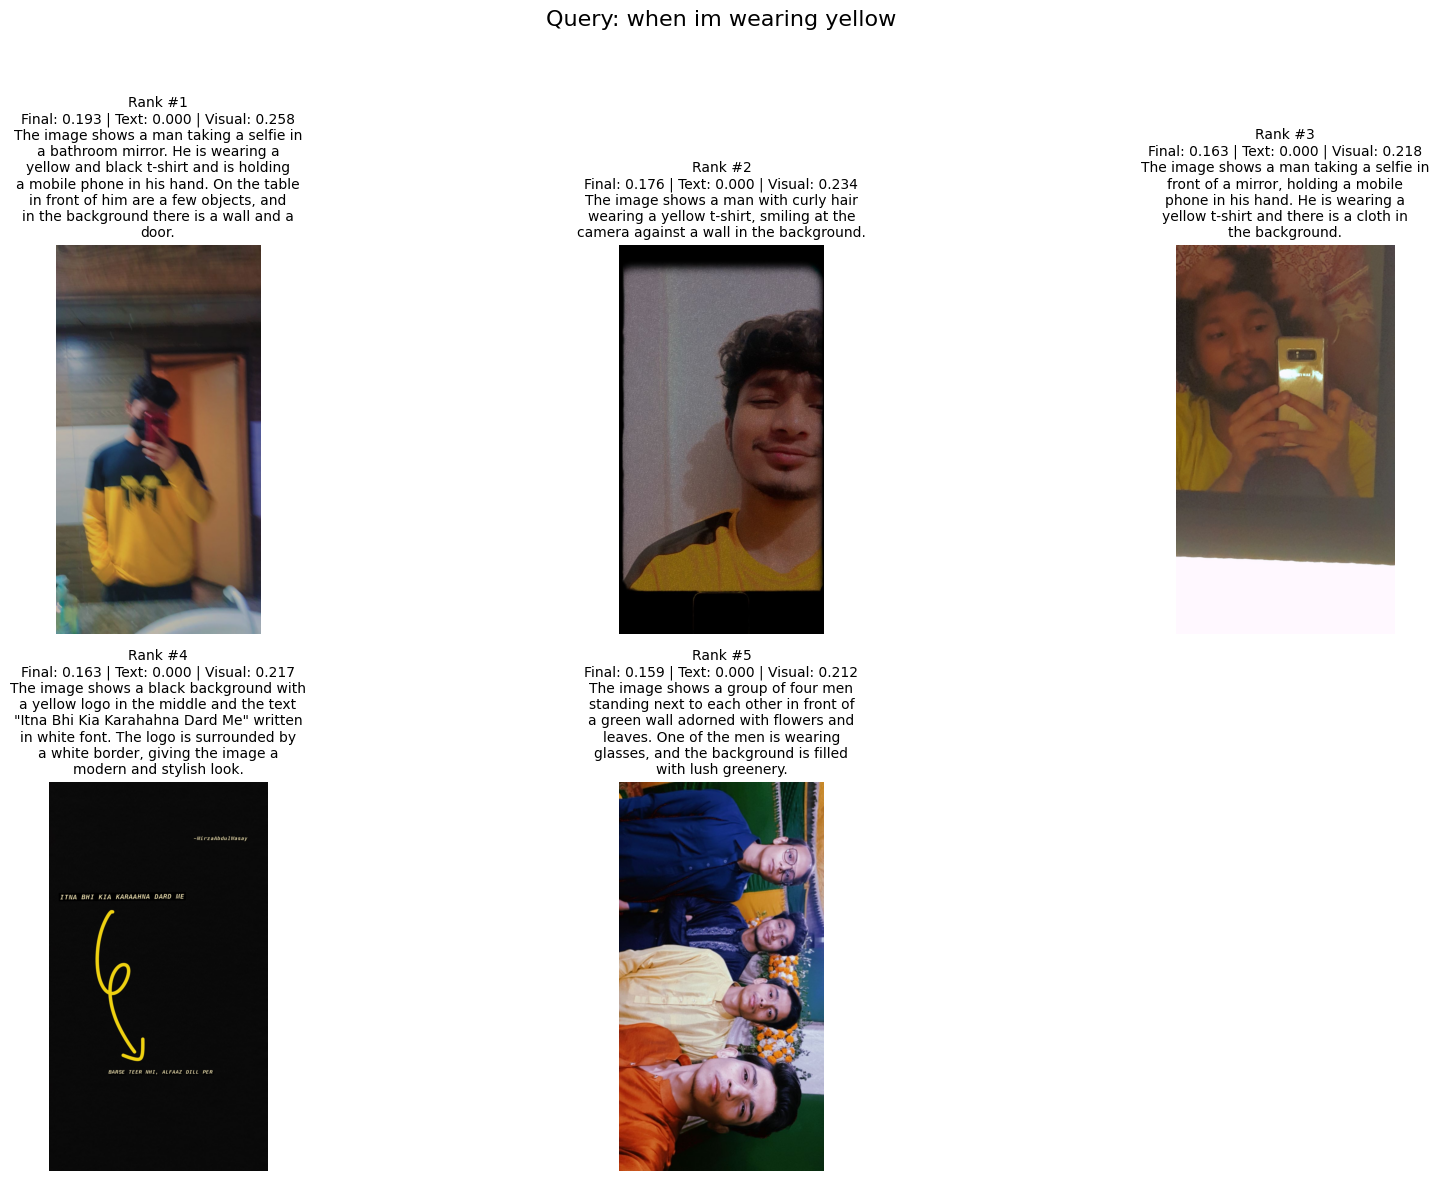

In [50]:
query = "when im wearing yellow"
results = search_memories(
    query,
    top_k=5,
    text_weight=0.25,
    visual_weight=0.75,
    debug=True
)

show_ranked_results(results, query)


In [61]:
# ==============================================================================
# CELL 1: Installation (Run this first)
# ==============================================================================

# !pip install -q gradio

# ==============================================================================
# CELL 2: Gradio Web UI - Full Screen Gallery (Run after your existing inference code)
# ==============================================================================

import gradio as gr

def format_result_info(result, rank):
    """Format result metadata as HTML"""
    info = f"""
    <div style="padding: 10px; background-color: #f0f0f0; border-radius: 5px; margin-bottom: 10px;">
        <h3 style="margin-top: 0;">Rank #{rank}</h3>
        <p><strong>Final Score:</strong> {result['final_score']:.3f}</p>
        <p><strong>Text Score:</strong> {result['text_score']:.3f} | <strong>Visual Score:</strong> {result['visual_score']:.3f}</p>
        <p><strong>Caption:</strong> {result['caption'] or 'No caption'}</p>
        <p><strong>Date:</strong> {result['date'] or 'Unknown'}</p>
        <p><strong>Location:</strong> {result['location'] or 'Unknown'}</p>
    </div>
    """
    return info

def search_interface(query, num_results, text_weight, visual_weight):
    """
    Main search function for Gradio interface
    Returns: images and their metadata
    """
    if not query.strip():
        return [], "Please enter a search query"

    try:
        # Normalize weights
        total = text_weight + visual_weight
        text_weight = text_weight / total
        visual_weight = visual_weight / total

        results = search_memories(
            query=query,
            top_k=num_results,
            text_weight=text_weight,
            visual_weight=visual_weight
        )

        if not results:
            return [], "No results found"

        # Prepare output
        gallery_images = []
        info_html = f"<h2>Search Results for: '{query}'</h2>"

        for i, result in enumerate(results, 1):
            # Load image
            img = Image.open(result["image_path"]).convert("RGB")

            # Create caption for gallery
            caption = (
                f"Rank #{i} | Score: {result['final_score']:.3f}\n"
                f"{result['caption'][:100]}..." if len(result['caption']) > 100 else result['caption']
            )

            gallery_images.append((img, caption))

            # Add detailed info
            info_html += format_result_info(result, i)

        return gallery_images, info_html

    except Exception as e:
        return [], f"Error: {str(e)}"

# -------------------- CREATE GRADIO APP --------------------

custom_css = """
/* Full height layout */
.gradio-container {
    max-width: 100% !important;
    padding: 0 !important;
}

/* Make gallery full height */
.gallery-container {
    min-height: calc(100vh - 300px) !important;
    max-height: calc(100vh - 300px) !important;
}

/* Improve gallery grid */
.grid-wrap {
    gap: 15px !important;
}

/* Better image display */
.gallery img {
    border-radius: 8px !important;
}

/* Search controls styling */
.search-section {
    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
    padding: 20px;
    border-radius: 10px;
    color: white;
}
"""

with gr.Blocks(title="Snapchat Memories Search", theme=gr.themes.Soft(), css=custom_css) as app:

    gr.Markdown(
        """
        # 📸 Snapchat Memories Search
        Search your Snapchat memories using natural language queries.
        ### Built by Mirza Abdul Wasay
        """
    )

    # Search controls in a compact row
    with gr.Row():
        query_input = gr.Textbox(
            label="Search Query",
            placeholder="e.g., 'food pictures', 'at the beach', 'with friends'",
            scale=3
        )

        num_results = gr.Slider(
            minimum=1,
            maximum=30,
            value=12,
            step=1,
            label="Results",
            scale=1
        )

        search_btn = gr.Button("🔍 Search", variant="primary", scale=1, size="lg")

    # Weight controls in collapsible section
    with gr.Accordion("⚙️ Advanced Settings", open=False):
        with gr.Row():
            text_weight = gr.Slider(
                minimum=0,
                maximum=1,
                value=0.25,
                step=0.05,
                label="Text Weight (Caption Similarity)",
                info="How much to weight caption/text matching"
            )

            visual_weight = gr.Slider(
                minimum=0,
                maximum=1,
                value=0.75,
                step=0.05,
                label="Visual Weight (Image Similarity)",
                info="How much to weight visual similarity"
            )

        gr.Markdown(
            """
            **Tips:** Adjust weights to balance text vs visual search. Higher text weight = more caption-focused. Higher visual weight = more image-focused.
            """
        )

    # Full-height gallery
    gallery = gr.Gallery(
        label="Search Results",
        show_label=False,
        columns=4,
        height=650,
        object_fit="cover",
        allow_preview=True,
        preview=True
    )

    # Detailed results in expandable accordion
    with gr.Accordion("📊 Detailed Results & Scores", open=False):
        info_output = gr.HTML()

    # Quick search examples
    gr.Markdown(
        """
        ---
        **Quick Examples:** Try searching for: `food pictures` • `sunset photos` • `with my dog` • `at the beach` • `selfies` • `group photos`
        """
    )

    # Event handlers
    search_btn.click(
        fn=search_interface,
        inputs=[query_input, num_results, text_weight, visual_weight],
        outputs=[gallery, info_output]
    )

    # Also trigger on Enter key
    query_input.submit(
        fn=search_interface,
        inputs=[query_input, num_results, text_weight, visual_weight],
        outputs=[gallery, info_output]
    )

# -------------------- LAUNCH --------------------

app.launch(
    share=True,  # Creates a public link you can share
    debug=True,
    inline=False  # Opens in new tab for better viewing
)

/tmp/ipython-input-129263101.py:109: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(title="Snapchat Memories Search", theme=gr.themes.Soft(), css=custom_css) as app:
/tmp/ipython-input-129263101.py:109: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(title="Snapchat Memories Search", theme=gr.themes.Soft(), css=custom_css) as app:


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d980e664a3f90dd0a4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://d980e664a3f90dd0a4.gradio.live
